# Bibliotecas

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from category_encoders import BinaryEncoder, CountEncoder
from sklearn.impute import SimpleImputer
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, r2_score

import xgboost as xgb

import pickle

# Carregando dados

In [2]:
df = pd.read_csv('data/train_cleaned.csv')

# Modelagem

## Regressão Linear

### Preparar dataset

In [3]:
# Definir as colunas categóricas e numéricas
categorical_cols_binary = ['NearestStation', 'Use']
categorical_cols_frequency = ['Type', 'Region', 'LandShape', 'Structure', 'Direction', 'Classification', 'CityPlanning']
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('TradePrice_log') # remove o target para ele não ser processado no pipeline

In [6]:
# Separar características e alvo
X = df.drop(columns=['TradePrice_log'])
y = df['TradePrice_log']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Criar pipeline
Pré-processamento e modelo de RL.

Encoding das categóricas:
- NearestStation, Use = Binary Encoding ou Frequency Encoding
- Outras: Frequency Encoding

In [7]:
# Criar o ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Imputa valores faltantes
            ('scaler', StandardScaler())                # Normaliza os dados
        ]), numeric_cols),
        
        ('binary', BinaryEncoder(cols=categorical_cols_binary), categorical_cols_binary),
        
        ('freq', CountEncoder(), categorical_cols_frequency)
    ],
    remainder='passthrough'  # Inclui todas as outras colunas que não estão listadas acima
)

In [17]:
# Criar o pipeline completo com o preprocessor e o modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Modelo de Regressão Linear
])


### Treinar Modelo e fazer previsões

In [18]:
# Ajustar o pipeline aos dados de treino
pipeline.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = pipeline.predict(X_test)

### Avaliar modelo

In [12]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, r2_score
import pandas as pd

# Previsões com o melhor modelo
y_pred = best_model.predict(X_test)

# Calcular RMLSE
rmlse = (mean_squared_log_error(y_test, y_pred))**0.5

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calcular R^2
r2 = r2_score(y_test, y_pred)

# Criar um DataFrame temporário para armazenar as métricas
temp_metrics_df = pd.DataFrame({
    'Model': ['Best Model'],
    'RMLSE': [rmlse],
    'MAPE': [mape],
    'R2': [r2]
})

# Supondo que 'metrics_df' é o DataFrame de métricas existente
# Concatenar o DataFrame temporário com o DataFrame de métricas existente
metrics_df = pd.concat([metrics_df, temp_metrics_df], ignore_index=True)

# Exibir o DataFrame atualizado com as métricas arredondadas
print(metrics_df.round(4))


               Model   RMLSE    MAPE     R2
0  Linear Regression  0.0304  0.0232  0.424


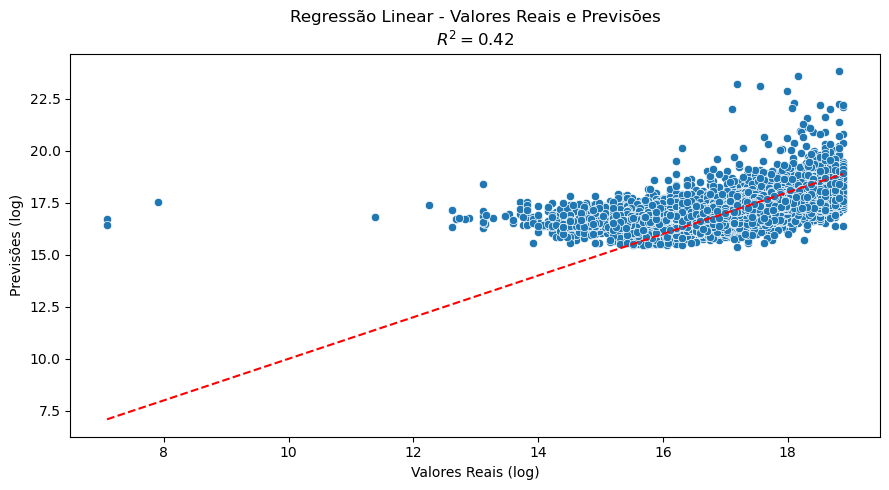

In [97]:
# Criar um DataFrame para facilitar a plotagem
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotar
plt.figure(figsize=(9, 5))
sns.scatterplot(data=results, x='Actual', y='Predicted')
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()],
         color='red', linestyle='--')
plt.xlabel('Valores Reais (log)')
plt.ylabel('Previsões (log)')
plt.title(f'Regressão Linear - Valores Reais e Previsões\n$R^2 = {r2:.2f}$')

plt.tight_layout()
plt.savefig('img/rl.png')
plt.show()

### Otimizando o modelo

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

# Passo 1: Criar um esquema de validação cruzada
folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Passo 2: Especificar o intervalo de hiperparâmetros para ajuste
hyper_params = [{'feature_selector__n_features_to_select': list(range(1, X_train.shape[1] + 1))}]

# Passo 3: Realizar a busca em grade
# 3.1 Criar o modelo de regressão
lm = LinearRegression()

# 3.2 Criar o RFE
rfe = RFE(estimator=lm)

# 3.3 Criar o pipeline completo com o preprocessor e o RFE
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', rfe),           # Adicionar o RFE ao pipeline
    ('regressor', lm)                    # Modelo de Regressão Linear
])

# 3.4 Chamar GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, 
                        param_grid=hyper_params, 
                        scoring='r2', 
                        cv=folds, 
                        verbose=1, 
                        return_train_score=True)

# Ajustar o modelo
model_cv.fit(X_train, y_train)

# Melhor modelo otimizado
best_model = model_cv.best_estimator_


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Previsões com o melhor modelo
y_pred = best_model.predict(X_test)

# Calcular as métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Criar um dicionário com as métricas
metrics_dict = {
    'Model': ['Best Model'],
    'MSE': [mse],
    'R2': [r2]
}

# Criar um DataFrame com as métricas
metrics_df1 = pd.DataFrame(metrics_dict)

# Supondo que 'metrics_df_all' é o DataFrame de métricas existente
# Concatenar com o DataFrame de métricas
metrics_df = pd.concat([metrics_df, metrics_df1], ignore_index=True)

# Exibir o DataFrame atualizado
print(metrics_df)


## XGBoost

### Preparar Pipeline

In [99]:
# Criar o pipeline para o XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

### Preparar dataset

In [100]:
# Dividir o dataset em treino e teste
X = df.drop(columns='TradePrice_log')
y = df['TradePrice_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Treinar modelo

In [101]:
# Treinar o modelo XGBoost
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MunicipalityCode',
                                                   'MaxTimeToNearestStation',
                                                   'Area', 'Frontage',
                                                   'BuildingYear', 'Breadth',
                                                   'CoverageRatio',
                                                   'FloorAreaRatio', 'Year',
                                                   'Quarter']),
                                                 ('binary',
                                                  BinaryEncoder(cols=['NearestSt...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Fazer previsões

In [102]:
# Fazer previsões
y_pred = pipeline_xgb.predict(X_test)

# Calcular as métricas
rmlse_xgb = (mean_squared_log_error(y_test, y_pred))**0.5
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)


### Avaliar modelo

In [103]:
# Criar um DataFrame com as métricas do XGBoost
metrics_xgb_df = pd.DataFrame({
    'Model': ['XGBoost'],
    'RMLSE': [rmlse_xgb],
    'MAPE': [mape_xgb],
    'R2': [r2_xgb]
})

# Atualizar o DataFrame com as métricas do XGBoost
metrics_df = pd.concat([metrics_df, metrics_xgb_df], ignore_index=True)

print(metrics_df.round(4))

               Model   RMLSE    MAPE     R2
0  Linear Regression  0.0304  0.0232  0.424
1            XGBoost  0.0174  0.0110  0.825


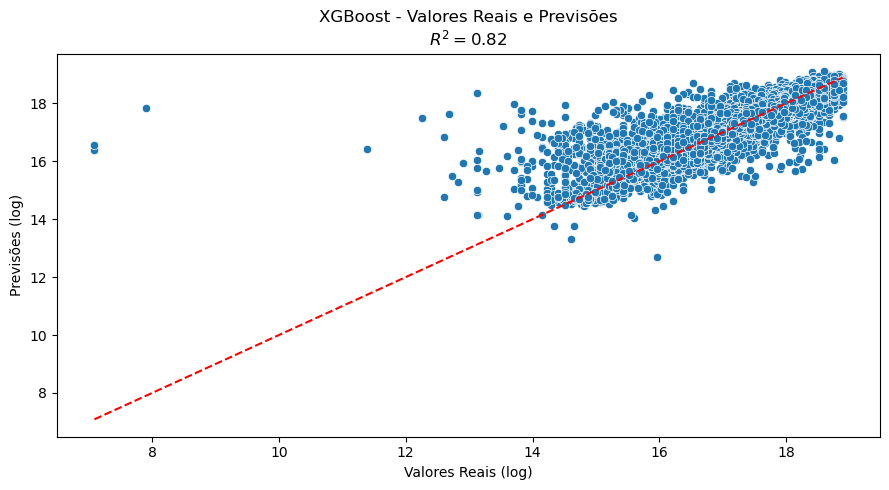

In [104]:
# Criar um DataFrame para facilitar a plotagem
results_xgb = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotar
plt.figure(figsize=(9, 5))
sns.scatterplot(data=results_xgb, x='Actual', y='Predicted')
plt.plot([results_xgb['Actual'].min(), results_xgb['Actual'].max()],
         [results_xgb['Actual'].min(), results_xgb['Actual'].max()],
         color='red', linestyle='--')
plt.xlabel('Valores Reais (log)')
plt.ylabel('Previsões (log)')
plt.title(f'XGBoost - Valores Reais e Previsões\n$R^2 = {r2_xgb:.2f}$')

plt.tight_layout()
plt.savefig('img/xgb.png')
plt.show()

## Gravando melhor modelo
Vou gravar o pipeline completo, incluindo as transformações.

In [107]:
# Gravar o pipeline completo em um arquivo pickle
with open('models/pipeline_xgb.pkl', 'wb') as file:
    pickle.dump(pipeline_xgb, file)